# Methods and Parameters for Linking

Linking assigns the detected features and segments in each timestep to trajectories, to enable an analysis of their time evolution. We will cover the topics:

- [Understanding the Linking Output](#Understanding-the-Linking-Output)
- [Defining a Search Radius](#Defining-a-Search-Radius)
- [Working with the Subnetwork](#Working-with-the-Subnetwork)
- [Timescale of the Tracks](#Timescale-of-the-Tracks)
- [Gappy Tracks](#Gappy-Tracks)
- [Other Parameters](#Other-Parameters)

We start by loading the usual libraries:

In [1]:
import tobac
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import seaborn as sns

sns.set_context("talk")

## Understanding the Linking Output

Since it has a time dimension, the sample data from the testing utilities is also suitable for a demonstration of this step. At first, loading in the data and performing the usual feature detection is required:

In [2]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs_inv()
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(
    data, dxy, threshold=1
)

Now the linking via trackpy can be performed. Notice that the temporal spacing is also a required input this time. Additionally, it is necessary to provide either a maximum speed *v_max* or a maximum search range *d_max*. Here we use a maximum speed of 100 m/s:

In [3]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max=100)

Frame 69: 2 trajectories present.


The output tells us, that in frame 69 two trajecteries where present. If we checkout this frame via imshow, we can see that this corresponds to the two present features there, which are assigned to different trajectories.

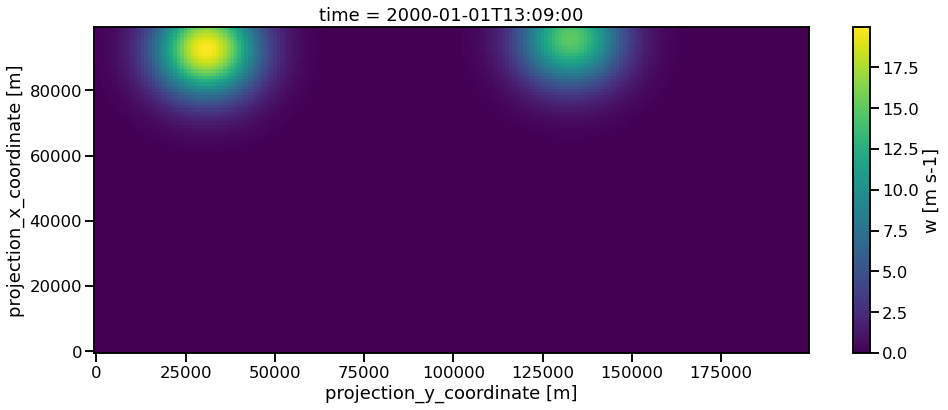

In [4]:
plt.figure(figsize=(16, 6))
data.isel(time=69).plot()

The track dataset contains two new variables, *cell* and *time_cell*. The first assigns the features to one of the found trajectories by an integer and the second specifies how long the feature has been present already in the data.

In [5]:
track[["cell", "time_cell"]]

<xarray.Dataset>
Dimensions:    (index: 110)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7 ... 102 103 104 105 106 107 108 109
Data variables:
    cell       (index) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 3.0 2.0 3.0 2.0 3.0
    time_cell  (index) timedelta64[ns] 00:00:00 00:01:00 ... 00:29:00 00:19:00

Since we know that this dataset contains 3 features, whe can visualize the found tracks with masks created from the *cell* variable:

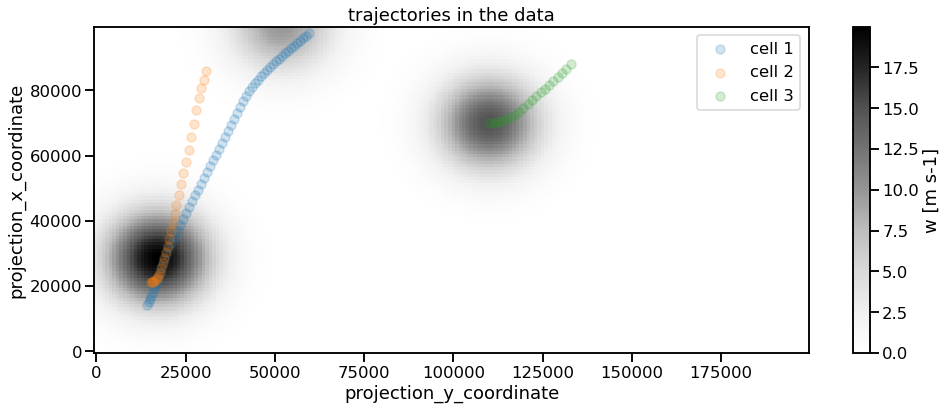

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

data.isel(time=50).plot(ax=ax, cmap="Greys")

for i, cell_track in track.groupby("cell"):

    index = int(cell_track["cell"].data[0])

    cell_track.plot.scatter(
        y="projection_x_coordinate",
        x="projection_y_coordinate",
        ax=ax,
        marker="o",
        alpha=0.2,
        label="cell {0}".format(index),
    )

ax.set_title("trajectories in the data")
plt.legend()

The starting point of the cell index if of course arbitrary. If we want to change it from 1 to 0 we can do this with the `cell_number_start` parameter:

Frame 69: 2 trajectories present.


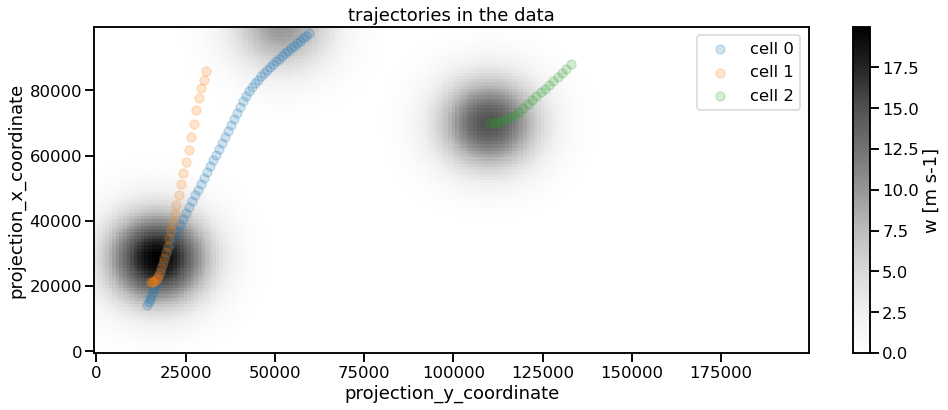

In [7]:
track = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt=dt, dxy=dxy, v_max=100, cell_number_start=0
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

data.isel(time=50).plot(ax=ax, cmap="Greys")

for i, cell_track in track.groupby("cell"):

    index = int(cell_track["cell"].data[0])

    cell_track.plot.scatter(
        y="projection_x_coordinate",
        x="projection_y_coordinate",
        ax=ax,
        marker="o",
        alpha=0.2,
        label="cell {0}".format(index),
    )

ax.set_title("trajectories in the data")
plt.legend()

The linking in `tobac` is performed with methods of the [trackpy](https://soft-matter.github.io/trackpy/v0.5.0/ )-library. Currently, there are two methods implemented, ['random'](https://soft-matter.github.io/trackpy/dev/generated/trackpy.link.html) and ['predict'](https://soft-matter.github.io/trackpy/v0.3.0/generated/trackpy.predict.NearestVelocityPredict.html). These can be selected with the `method` keyword. The default is 'random'.

In [8]:
track = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt=dt, dxy=dxy, v_max=100, method_linking="predict"
)

Frame 69: 2 trajectories present.


## Defining a Search Radius

If you paid attention to the input of the `linking_trackpy()` function you noticed that we used the parameter `v_max` there. The reason for that it would take a lot of computation time to check the whole data of a frame for the next position of a feature from the previous frame. Therefore the search is restricted to a circle around a position predicted by the [Crocker-Grier linking algorithm](http://dx.doi.org/10.1006/jcis.1996.0217), which is implemented in *trackpy*.

The speed we defined before specifies such a radius timestep via

$$
r_{max} = v_{max} \Delta t.
$$

By reducing the maximum speed fromm 100 m/s to 70 m/s we will find more cells, because a feature that is not assigned to an existing track will be used as a starting point for a new one:

Frame 69: 2 trajectories present.


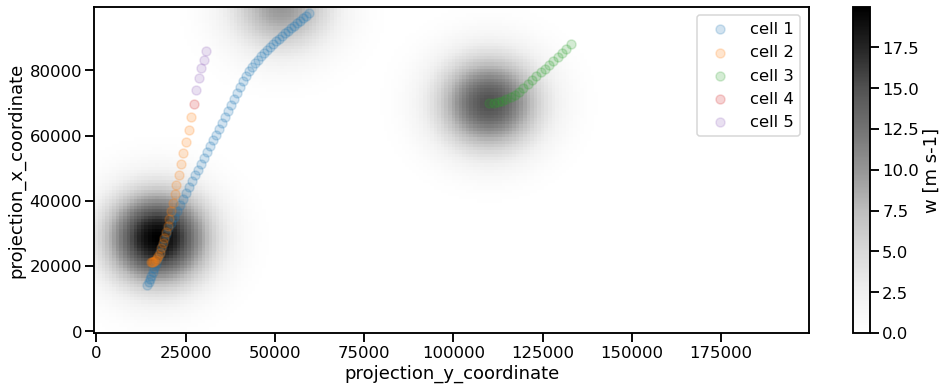

In [9]:
track = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt=dt, dxy=dxy, v_max=70, method_linking="predict"
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

data.isel(time=50).plot(ax=ax, cmap="Greys")

for i, cell_track in track.groupby("cell"):
    cell_track.plot.scatter(
        y="projection_x_coordinate",
        x="projection_y_coordinate",
        ax=ax,
        marker="o",
        alpha=0.2,
        label="cell {0}".format(int(i)),
    )

plt.legend()

The same effect can be achieved by directly reducing the maximum search range with the `d_max` parameter to

$$
d_{max} = 4200 m
$$

because

$$
v_{max} \Delta t = 4200 m
$$

for $v_{max} = 70$ m/s in our case.

Frame 69: 2 trajectories present.


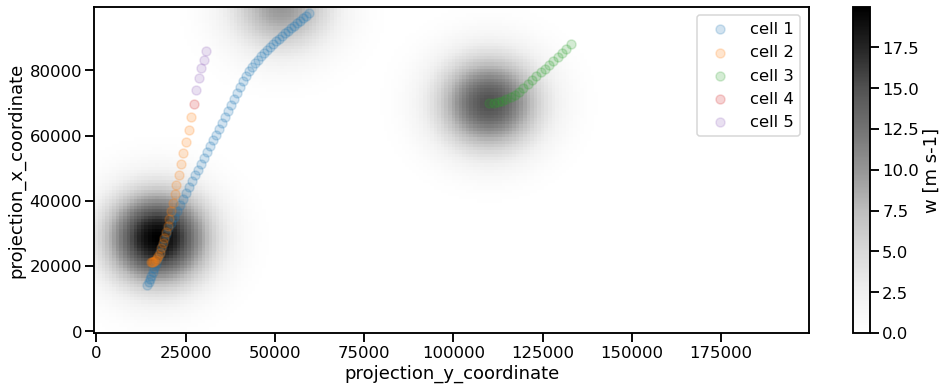

In [10]:
track = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt=dt, dxy=dxy, d_max=4200, method_linking="predict"
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

data.isel(time=50).plot(ax=ax, cmap="Greys")

for i, cell_track in track.groupby("cell"):
    cell_track.plot.scatter(
        y="projection_x_coordinate",
        x="projection_y_coordinate",
        ax=ax,
        marker="o",
        alpha=0.2,
        label="cell {0}".format(int(i)),
    )

plt.legend()

*v_max* and *d_max* should not be used together, because they both specify the same qunatity, namely the search range, but it is neccery to set at least one of these parameters.

## Working with the Subnetwork

If we increase *v_max* or *d_max* it can happen that more than one feature of the previous timestep is in the search range. The selection of the best matching feature from the set of possible features (which is called the subnetwork, for a more in depth explanation have a look [here](https://soft-matter.github.io/trackpy/v0.3.0/tutorial/subnets.html)) is the most time consuming part of the linking process. For this reason, it is possible to limit the number of features in the search range via the `subnetwork_size` parameter. The tracking will result in a **trackpy.SubnetOversizeException** if more features than specified there are in the search range. We can simulate this situation by setting a really high value for `v_max` and 1 for the `subnetwork_size`:

In [11]:
from trackpy import SubnetOversizeException

try:

    track = tobac.themes.tobac_v1.linking_trackpy(
        features, data, dt=dt, dxy=dxy, v_max=1000, subnetwork_size=1
    )
    print("tracking successful")
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 4))
    ax.imshow(data[0], alpha=0)

    for i, cell_track in enumerate(track.groupby("cell")):
        ax.plot(
            cell_track[1]["hdim_2"],
            cell_track[1]["hdim_1"],
            marker=".",
            linestyle="",
            label="cell {}".format(i + 1),
        )

    ax.legend()
    plt.show()

except SubnetOversizeException as e:

    print("Tracking not possible because the {}".format(e))

Frame 57: 3 trajectories present.
Tracking not possible because the Subnetwork contains 2 points


The default value for this parameter is 30 and can be accessed via:

In [12]:
import trackpy as tp

tp.linking.Linker.MAX_SUB_NET_SIZE

1

It is important to highlight that if the `linking_trackpy()`-function is called with a `subnetwork_size` different from 30, this number will be the new default. This is the reason, why the value is 1 at this point.

### Adaptive Search

A way of dealing with **SubnetOversizeException**s is adapative search. An extensive description can be found [here](https://soft-matter.github.io/trackpy/v0.3.0/tutorial/adaptive-search.html).

If the subnetwork is too large, the search range is reduced iterativly by multiplying it with the `adaptive_step`. The `adaptive_stop`-parameter is the lower limit of the search range. If it is reached and the subnetwork is still to large, a **SubnetOversizeException** is thrown. Notice that as soon as adaptiv search is used, a different limit of the subnetwork size applies, which needs to be specified by hand at the moment:

In [13]:
tp.linking.Linker.MAX_SUB_NET_SIZE_ADAPTIVE = 1

Now the tracking can be performed and will no longer result in an exception:

Frame 69: 2 trajectories present.
tracking successful!


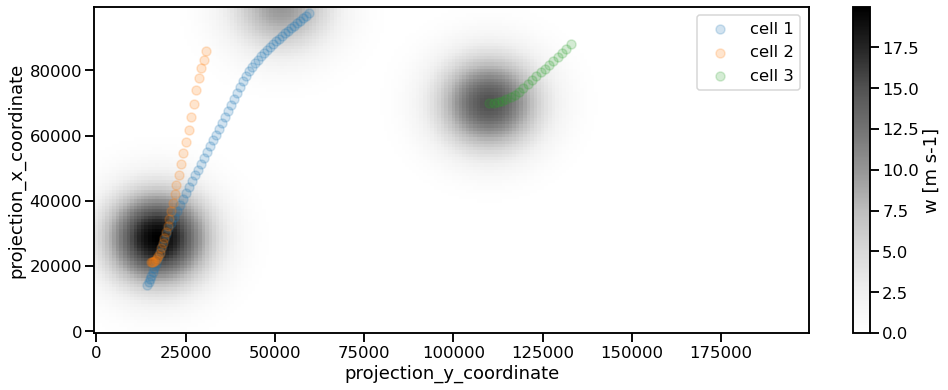

In [14]:
try:

    track = tobac.themes.tobac_v1.linking_trackpy(
        features, data, dt=dt, dxy=dxy, v_max=1000, adaptive_stop=10, adaptive_step=0.9
    )
    print("tracking successful!")

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

    data.isel(time=50).plot(ax=ax, cmap="Greys")

    for i, cell_track in track.groupby("cell"):
        cell_track.plot.scatter(
            y="projection_x_coordinate",
            x="projection_y_coordinate",
            ax=ax,
            marker="o",
            alpha=0.2,
            label="cell {0}".format(int(i)),
        )

    plt.legend()

except SubnetOversizeException as e:

    print("Tracking not possible because the {}".format(e))

If `adaptive_stop` is specified, `adaptive_step` needs to be specified as well.

## Timescale of the Tracks

If we want to limit our analysis to long living features of the dataset it is possible to exclude tracks which only cover few timesteps. This is done by setting a lower bound for those via the `stups` parameter. In our test data, only the first cell exceeds 50 time steps:

Frame 69: 2 trajectories present.


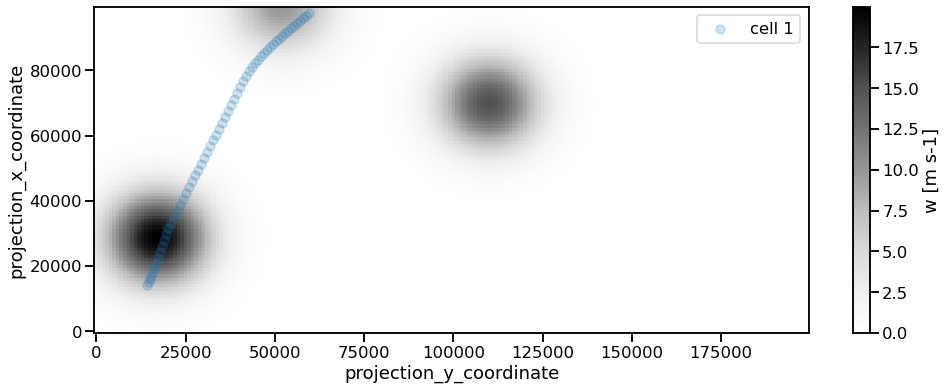

In [15]:
track = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt=dt, dxy=dxy, v_max=100, stubs=50
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

data.isel(time=50).plot(ax=ax, cmap="Greys")

for i, cell_track in track.groupby("cell"):
    cell_track.plot.scatter(
        y="projection_x_coordinate",
        x="projection_y_coordinate",
        ax=ax,
        marker="o",
        alpha=0.2,
        label="cell {0}".format(int(i)),
    )

plt.legend()

Analogius to the search range, there is a second option for that called *time_cell_min*. This defines a minimum of time in minutes for a cell to appear as tracked:

Frame 69: 2 trajectories present.


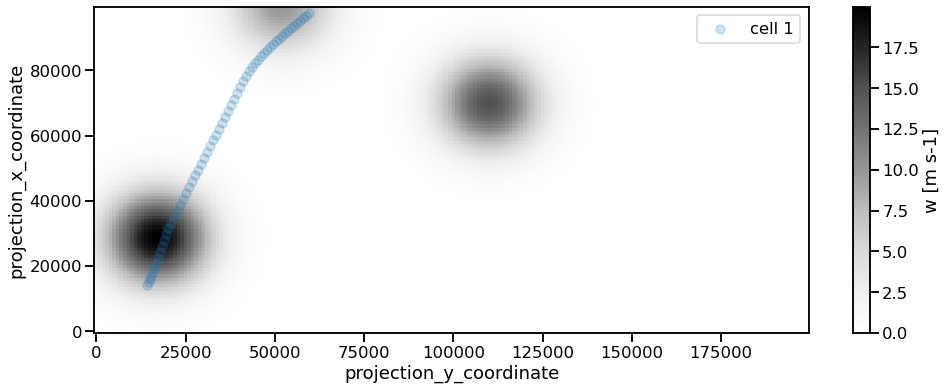

In [16]:
track = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt=dt, dxy=dxy, v_max=100, time_cell_min=3000
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

data.isel(time=50).plot(ax=ax, cmap="Greys")

for i, cell_track in track.groupby("cell"):
    cell_track.plot.scatter(
        y="projection_x_coordinate",
        x="projection_y_coordinate",
        ax=ax,
        marker="o",
        alpha=0.2,
        label="cell {0}".format(int(i)),
    )

plt.legend()

## Gappy Tracks
  
If the data is noisy, an object may disappear for a few frames and then reappear. Such features can still be linked by setting the `memory` parameter with an integer. This defines the number of timeframes a feature can vanish and still get tracked as one cell. We demonstrate this on a simple dataset with only one feature:

Frame 59: 1 trajectories present.


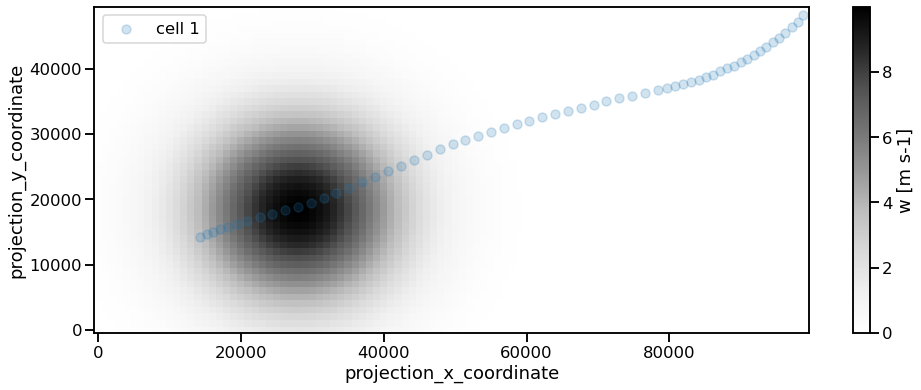

In [17]:
data = tobac.testing.make_simple_sample_data_2D()
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(
    data, dxy, threshold=1
)
track = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt=dt, dxy=dxy, v_max=1000
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

data.isel(time=10).plot(ax=ax, cmap="Greys")

for i, cell_track in track.groupby("cell"):
    cell_track.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax,
        marker="o",
        alpha=0.2,
        label="cell {0}".format(int(i)),
    )

plt.legend()
plt.show()

To simulate a gap in the data we set 5 timeframes to 0:

In [18]:
data[30:35] = data[30] * 0

If we apply feature detection and linking to this modified dataset, we will now get two cells:

Frame 59: 1 trajectories present.


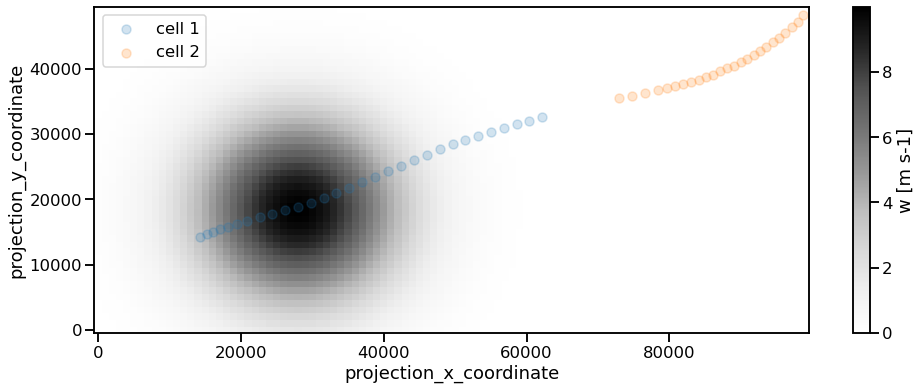

In [19]:
features = tobac.themes.tobac_v1.feature_detection_multithreshold(
    data, dxy, threshold=1
)
track = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt=dt, dxy=dxy, v_max=1000
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

data.isel(time=10).plot(ax=ax, cmap="Greys")

for i, cell_track in track.groupby("cell"):
    cell_track.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax,
        marker="o",
        alpha=0.2,
        label="cell {0}".format(int(i)),
    )

plt.legend()
plt.show()

We can avoid that by setting `memory` to a sufficiently high number. 5 is of course sufficient in our case as the situation is artificially created, but with real data this would require some fine tuning. Keep in mind that the search radius needs to be large enough to reach the next feature position. This is the reason for setting `v_max` to 1000 in the linking process.

Frame 59: 1 trajectories present.


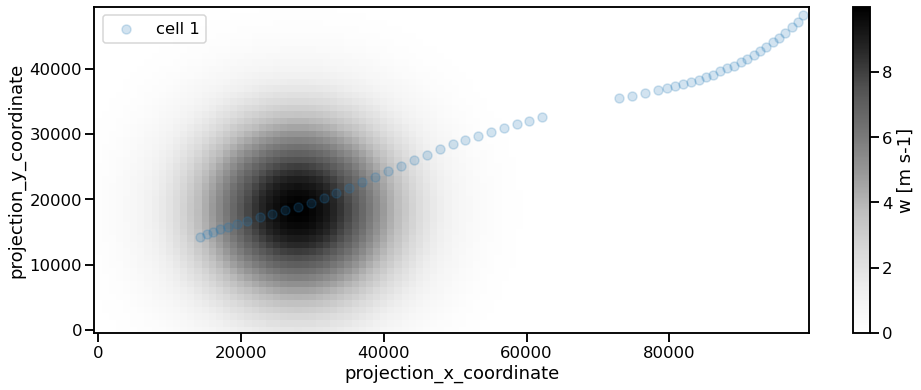

In [20]:
features = tobac.themes.tobac_v1.feature_detection_multithreshold(
    data, dxy, threshold=1
)
track = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt=dt, dxy=dxy, v_max=1000, memory=5
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

data.isel(time=10).plot(ax=ax, cmap="Greys")

for i, cell_track in track.groupby("cell"):
    cell_track.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax,
        marker="o",
        alpha=0.2,
        label="cell {0}".format(int(i)),
    )

plt.legend()
plt.show()

## Other Parameters

The parameters `d_min_`, `extrapolate` and `order` do not have a working implmentation in tobac V2 at the moment.